# Experiment for Signature Verification
Source: [SVC2004](https://www.cse.ust.hk/svc2004/)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random
%matplotlib inline

## Read Images

In [3]:
def getSignature(uid, sid) :
    if 1 <= uid <= 40 and 1 <= sid <= 40 :
        src = '../data/user{}/'+ ('genuine' if 1 <= sid <= 20 else 'forged') +'/U{}S{}.jpg'
        src = src.format(uid, uid, sid)
        return cv2.resize(cv2.imread(src, cv2.IMREAD_GRAYSCALE), (900, 600))
    else :
        return None

def getGenuineSignature(uid, sid = -1) :
    if sid == -1: sid = random.randint(1, 20)
    return getSignature(uid, sid)

def getForgedSignature(uid, sid = -1) :
    if sid == -1: sid = random.randint(21, 40)
    if sid <= 20: sid += 20
    return getSignature(uid, sid)


## Visualization

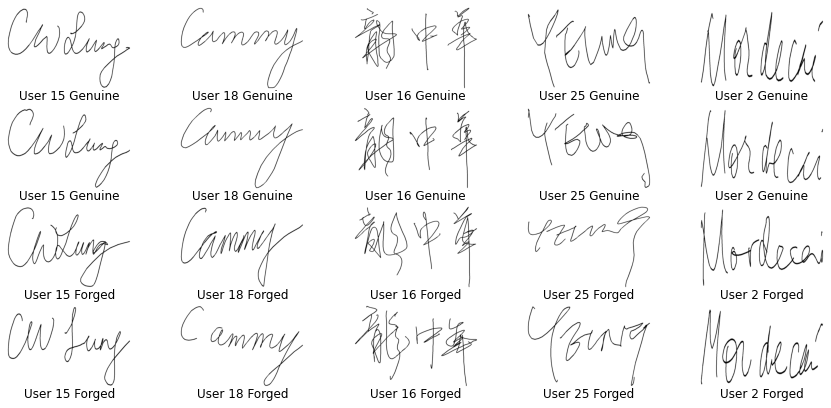

In [4]:
samples = 5
plt.figure(figsize = (15, 7))
for i in range(1, samples + 1) :
    uid = random.randint(1, 40)
    plt.subplot(4, samples, i)
    plt.axis('off')
    plt.title('User {} Genuine'.format(uid), y = -0.2)
    plt.imshow(getGenuineSignature(uid), cmap='gray')

    plt.subplot(4, samples, samples + i)
    plt.axis('off')
    plt.title('User {} Genuine'.format(uid), y = -0.2)
    plt.imshow(getGenuineSignature(uid), cmap='gray')
    
    plt.subplot(4, samples, samples * 2 + i)
    plt.axis('off')
    plt.imshow(getForgedSignature(uid), cmap='gray')
    plt.title('User {} Forged'.format(uid), y = -0.2)

    plt.subplot(4, samples, samples * 3 + i)
    plt.axis('off')
    plt.imshow(getForgedSignature(uid), cmap='gray')
    plt.title('User {} Forged'.format(uid), y = -0.2)

## Pre-Expreiment

### Feature Extraction

We extract feature from 1 reference genuine signature, 1 test genuine and 1 test forged signature. First, randomly pick 3 signatures of 1 user:

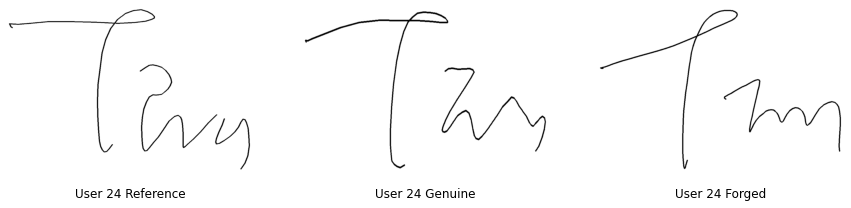

In [6]:
uid = random.randint(1, 40)
reference = getGenuineSignature(uid)
genuine = getGenuineSignature(uid)
forged = getForgedSignature(uid)

# Visualization
plt.figure(figsize = (15, 7))

plt.subplot(1, 3, 1)
plt.axis('off')
plt.title('User {} Reference'.format(uid), y = -0.2)
plt.imshow(reference, cmap='gray')

plt.subplot(1, 3, 2)
plt.axis('off')
plt.title('User {} Genuine'.format(uid), y = -0.2)
plt.imshow(genuine, cmap='gray')

plt.subplot(1, 3, 3)
plt.axis('off')
plt.title('User {} Forged'.format(uid), y = -0.2)
plt.imshow(forged, cmap='gray')

Next, use Canny detector to detect edges(lines) in signatures:

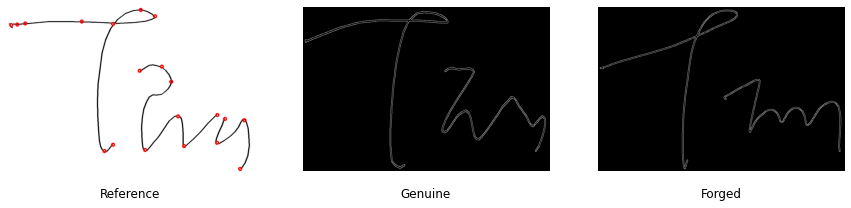

In [29]:

#reference_canny = cv2.Canny(reference, threshold1 = 30, threshold2 = 100)
dst = cv2.dilate(cv2.cornerHarris(reference, blockSize = 3, ksize = 3, k = 0.04), None)
pos = cv2.goodFeaturesToTrack(dst, 0, 0.01, 15).astype(np.int16)
reference_canny = reference.copy()
reference_canny = cv2.cvtColor(reference_canny, cv2.COLOR_GRAY2RGB)
for i in range(len(pos)):
    cv2.circle(reference_canny, (pos[i][0][0], pos[i][0][1]), 5, [255,0,0], thickness=3)
genuine_canny = cv2.Canny(genuine, threshold1 = 30, threshold2 = 100)
forged_canny = cv2.Canny(forged, threshold1 = 30, threshold2 = 100)

# Visualization
plt.figure(figsize = (15, 7))

plt.subplot(1, 3, 1)
plt.axis('off')
plt.title('Reference', y = -0.2)
plt.imshow(reference_canny, cmap='gray')

plt.subplot(1, 3, 2)
plt.axis('off')
plt.title('Genuine', y = -0.2)
plt.imshow(genuine_canny, cmap='gray')

plt.subplot(1, 3, 3)
plt.axis('off')
plt.title('Forged', y = -0.2)
plt.imshow(forged_canny, cmap='gray')

Moreover, extract SIFT features from images:

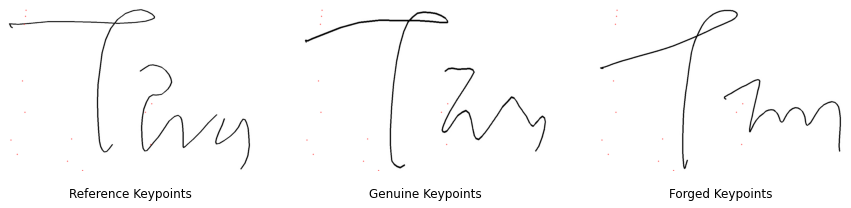

In [32]:
extractor = cv2.SIFT_create()

def detectAndCompute(image, spacing = 1) :
    # canny = cv2.Canny(image, threshold1 = 30, threshold2 = 100)
    # kp = [cv2.KeyPoint(x, y, size = 16) for x in range(0, image.shape[1], spacing) for y in range(0, image.shape[0], spacing) if canny[y, x] == 255]
    dst = cv2.dilate(cv2.cornerHarris(reference, blockSize = 3, ksize = 3, k = 0.04), None)
    pos = cv2.goodFeaturesToTrack(dst, 0, 0.01, 15).astype(np.int16)
    kp = [cv2.KeyPoint(pos[i][0][0], pos[i][0][1], size = 3) for i in range(len(pos))]
    _, des = cv2.SIFT_create().compute(image, kp)
    return kp, des

kp_ref, des_ref = detectAndCompute(reference)
kp_gen, des_gen = detectAndCompute(genuine)
kp_for, des_for = detectAndCompute(forged)

# kp_ref, des_ref = extractor.detectAndCompute(reference_canny, None)
# kp_gen, des_gen = extractor.detectAndCompute(genuine_canny, None)
# kp_for, des_for = extractor.detectAndCompute(forged_canny, None)

def getKeypointVisulization(image, keypoints) :
    return cv2.drawKeypoints(image, keypoints, image, (255, 0, 0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize = (15, 7))

plt.subplot(1, 3, 1)
plt.axis('off')
plt.title('Reference Keypoints', y = -0.2)
plt.imshow(getKeypointVisulization(reference, kp_ref))

plt.subplot(1, 3, 2)
plt.axis('off')
plt.title('Genuine Keypoints', y = -0.2)
plt.imshow(getKeypointVisulization(genuine, kp_gen))

plt.subplot(1, 3, 3)
plt.axis('off')
plt.title('Forged Keypoints', y = -0.2)
plt.imshow(getKeypointVisulization(forged, kp_for))


Now we try to match reference and genuine/forged signatures:

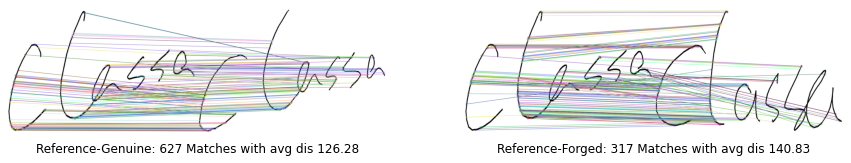

In [28]:
def getDivisionMatchesAndVisualization(img1, kp1, des1, img2, kp2, des2) :
    bf = cv2.BFMatcher(crossCheck = True)
    matches = []
    kp1_blocks = []
    kp2_blocks = []

    cols = 3
    rows = 2
    dx = img1.shape[1] // cols
    dy = img1.shape[0] // rows

    for x in range(cols) :
        for y in range(rows) :
            kp1_block = []
            des1_block = []
            kp2_block = []
            des2_block = []
            for kp, des in zip(kp1, des1):
                if (int(kp.pt[0]) // dx) == x and  (int(kp.pt[1]) // dy) == y :
                    kp1_block.append(kp)
                    des1_block.append(des)
            for kp, des in zip(kp2, des2):
                if (int(kp.pt[0]) // dx) == x and  (int(kp.pt[1]) // dy) == y :
                    kp2_block.append(kp)
                    des2_block.append(des)
            if len(des1_block) == 0 or len(des2_block) == 0 : continue
            
            matches_block = bf.match(np.array(des1_block), np.array(des2_block))
            matches_block = [cv2.DMatch(len(kp1_blocks)+match.queryIdx, len(kp2_blocks)+match.trainIdx, match.distance) for match in matches_block]
            matches += matches_block
            kp1_blocks += kp1_block
            kp2_blocks += kp2_block
    
    return matches, cv2.drawMatches(img1, kp1_blocks, img2, kp2_blocks, matches[::1+len(matches)//200], None, flags=2)


def getNaiveMatchesAndVisualization(img1, kp1, des1, img2, kp2, des2) :
    # Cross check
    bf = cv2.BFMatcher(crossCheck = True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key = lambda x:x.distance)

    # # Ratio test (alternative)
    # bf = cv2.BFMatcher()
    # matches = bf.knnMatch(des1, des2, k = 2)
    # good = []
    # for m,n in matches:
    #     if m.distance < 0.75 * n.distance:
    #         good.append(m)
    # matches = sorted(good, key = lambda x:x.distance)
    return matches, cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=2)

plt.figure(figsize = (15, 7))

matches, result_matches = getDivisionMatchesAndVisualization(reference, kp_ref, des_ref, genuine, kp_gen, des_gen)

plt.subplot(1, 2, 1)
plt.axis('off')

plt.title('Reference-Genuine: {} Matches with avg dis {:.2f}'.format(len(matches), np.mean(list(map(lambda x:x.distance, matches)))), y = -0.2)
plt.imshow(result_matches)

matches, result_matches = getDivisionMatchesAndVisualization(reference, kp_ref, des_ref, forged, kp_for, des_for)
plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Reference-Forged: {} Matches with avg dis {:.2f}'.format(len(matches), np.mean(list(map(lambda x:x.distance, matches)))), y = -0.2)
plt.imshow(result_matches)

## Naive Classification by Matches

Try to classify each user's signature using a Support Vector Machine.

In [29]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from tqdm import tqdm
x = []
y = []
for uid in tqdm(range(40)):
#for uid in [10]:
    for i in range(1, 21) :
        reference = getSignature(uid, i)
        kp_ref, des_ref = detectAndCompute(reference)
        
        for j in range(1, 41) :
            if i == j : continue
            verify = getSignature(uid, j)
            kp_ver, des_ver = detectAndCompute(verify)
            matches, _ = getDivisionMatchesAndVisualization(reference, kp_ref, des_ref, verify, kp_ver, des_ver)
            distances = list(map(lambda x:x.distance, matches))
            x.append([len(matches), np.mean(distances), np.var(distances)])
            y.append("genuine" if j <= 20 else "forged")
        
        noises = random.sample([noise_uid for noise_uid in range(1, 41) if noise_uid != uid], 10)
        for noise_uid in noises :
            verify = getGenuineSignature(noise_uid)
            kp_ver, des_ver = detectAndCompute(verify)
            matches, _ = getDivisionMatchesAndVisualization(reference, kp_ref, des_ref, verify, kp_ver, des_ver)
            distances = list(map(lambda x:x.distance, matches))
            x.append([len(matches), np.mean(distances), np.var(distances)])
            y.append("forged")

            verify = getForgedSignature(noise_uid)
            kp_ver, des_ver = detectAndCompute(verify)
            matches, _ = getDivisionMatchesAndVisualization(reference, kp_ref, des_ref, verify, kp_ver, des_ver)
            distances = list(map(lambda x:x.distance, matches))
            x.append([len(matches), np.mean(distances), np.var(distances)])
            y.append("forged")


100%|██████████| 20/20 [18:36<00:00, 55.85s/it]


In [33]:
print([(xx, yy) for xx, yy in zip(x, y)][::100])

x_num = np.array([ [xx[0]] for xx in x ])
x_num_avg = np.array([ [xx[0], xx[1]] for xx in x ])
x_num_avg_var = np.array(x)

x_train, x_test, y_train, y_test = train_test_split(x_num_avg_var, y, test_size = 0.2)

# # if use x_num, reshape x data:
# x_train = np.array(x_train).reshape(-1, 1)
# x_test = np.array(x_test).reshape(-1, 1)

[([394, 124.54192011973579, 7201.632552764899], 'genuine'), ([45, 303.28573905097113, 12048.295163456694], 'forged'), ([293, 107.81538214699808, 5124.054858930373], 'forged'), ([231, 149.10974841097217, 10871.638203770724], 'genuine'), ([139, 214.96105726502782, 11922.067944574244], 'forged'), ([103, 199.00085973276674, 8844.7645541521], 'forged'), ([306, 156.43426686953876, 6541.205644245485], 'genuine'), ([152, 264.79740207446247, 10480.125057827006], 'forged'), ([196, 180.76223690655766, 11335.94246540265], 'forged'), ([290, 179.04469207237506, 6257.980784108434], 'genuine'), ([97, 363.0965156161908, 4562.817412440195], 'forged'), ([352, 124.57523650472814, 7657.183714580241], 'forged')]


In [34]:
parameters = {
    'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}
model = SVC(kernel='rbf')
model_grid = GridSearchCV(model, param_grid = parameters)
model_grid.fit(x_train, y_train)

model_SVM = model_grid.best_estimator_
print(model_SVM)

# model_SVM = SVC(C=1)

model_SVM.fit(x_train, y_train)
y_pred = model_SVM.predict(x_test)

print(classification_report(y_test, y_pred))

SVC(C=1, gamma=0.1)
              precision    recall  f1-score   support

      forged       0.91      1.00      0.95       162
     genuine       1.00      0.78      0.88        74

    accuracy                           0.93       236
   macro avg       0.96      0.89      0.92       236
weighted avg       0.94      0.93      0.93       236



It is surprised that this method has very high recall for forged signatures. That is to say, it might be a highly-safe verification method.

In [32]:
def verify(reference, image) :
    kp_ref, des_ref = detectAndCompute(reference)
    kp_ver, des_ver = detectAndCompute(image)
    matches, _ = getDivisionMatchesAndVisualization(reference, kp_ref, des_ref, image, kp_ver, des_ver)
    distances = list(map(lambda x:x.distance, matches))
    return model_SVM.predict([[len(matches), np.mean(distances), np.var(distances)]])[0]

uid = 3
images_to_verify = [getGenuineSignature(uid), getGenuineSignature(random.randint(1, 41)),  getForgedSignature(uid), getForgedSignature(random.randint(1, 41))]
print([verify(getGenuineSignature(uid), image) for image in images_to_verify])

['forged', 'forged', 'forged', 'forged']
